In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import comb, exp, factorial, log

## Section 6.1: Probability {-}

### Section 6.1.1: Frequentist versus Bayesian {-}

### Section 6.1.2: Definition and Axioms {-}

### Section 6.1.3: Permutations {-}

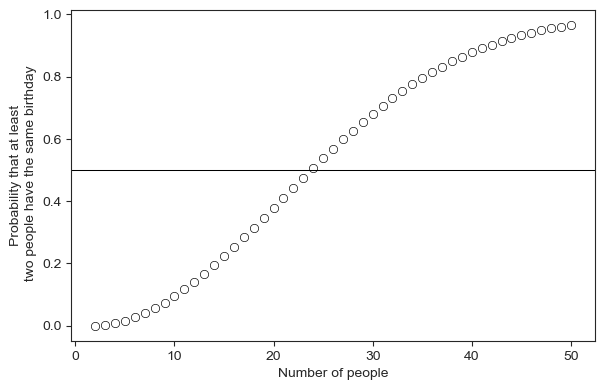

In [2]:
def birthday(k):
    logdenom = k * log(365) + log(factorial(365 - k)) # log denominator
    lognumer = log(factorial(365)) # log numerator
    # P(at least two have the same bday) = 1 - P(nobody has the same bday)
    pr = 1 - exp(lognumer - logdenom) # transform back
    return pr

k = pd.Series(np.arange(1, 51))

bday = k.apply(birthday) # apply the function to each element of k

bday.index = k # add labels 

sns.set_style('ticks')

sns.relplot(
    x=k, y=bday, color='white', edgecolor='black', height=4, aspect=1.5
).set(ylabel='Probability that at least\n two people have the same birthday',
      xlabel='Number of people').despine(right=False, top=False)

# horizontal line at 0.5
plt.axhline(0.5, color='black', linewidth=0.75)

In [3]:
bday.loc[20:25]

20    0.411438
21    0.443688
22    0.475695
23    0.507297
24    0.538344
25    0.568700
dtype: float64

### Section 6.1.4: Sampling With and Without Replacement {-}

In [4]:
k = 23 # number of people
sims = 10000 # number of simulations
event = 0 # initialize counter

for i in range(sims):
    days = np.random.choice(np.arange(1,366), size=k, replace=True)
    days_unique = np.unique(days) # number of unique days
    '''
    if there are duplicates, the number of unique birthdays will be less than
    the number of birthdays, which is 'k'
    '''
    if len(days_unique) < len(days):
        event += 1

answer = event / sims
answer

0.5054

### Section 6.1.5: Combinations {-}

In [5]:
comb(84, 6)

406481544

## Section 6.2: Conditional Probability {-}

### Section 6.2.1: Conditional, Marginal, and Joint Probabilities {-}

In [6]:
FLVoters = pd.read_csv('FLVoters.csv')

FLVoters.shape # before removal of missing data

(10000, 6)

In [7]:
FLVoters.info() # there is one missing surname

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   surname  9999 non-null   object 
 1   county   10000 non-null  int64  
 2   VTD      10000 non-null  int64  
 3   age      9992 non-null   float64
 4   gender   9992 non-null   object 
 5   race     9126 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 468.9+ KB


In [8]:
# print the record with the missing surname
FLVoters[FLVoters['surname'].isnull()]

,surname,county,VTD,age,gender,race
349,NaN,5,14,70.0,f,white


Looking at the raw data, it turns out that one voter's surname is Null. Pandas treated the name as missing. We need to override this behavior and treat Ms. Null's name as a string.

In [9]:
FLVoters.head() # the surnames are in all caps

,surname,county,VTD,age,gender,race
0,PIEDRA,115,66,58.0,f,white
1,LYNCH,115,13,51.0,m,white
2,CHESTER,115,103,63.0,m,NaN
3,LATHROP,115,80,54.0,m,white
4,HUMMEL,115,8,77.0,f,white


In [10]:
FLVoters['surname'] = np.where(
    FLVoters['surname'].isnull(), 'NULL', FLVoters['surname'])

FLVoters = FLVoters.dropna()

FLVoters.shape # after removal of missing data

(9113, 6)

In [11]:
margin_race = FLVoters['race'].value_counts(normalize=True).sort_index()

margin_race

race
asian       0.019203
black       0.131022
hispanic    0.130802
native      0.003182
other       0.034017
white       0.681773
Name: proportion, dtype: float64

In [12]:
margin_gender = FLVoters['gender'].value_counts(normalize=True)

margin_gender

gender
f    0.535828
m    0.464172
Name: proportion, dtype: float64

In [13]:
FLVoters['race'][FLVoters.gender == 'f'].value_counts(
    normalize=True).sort_index()

race
asian       0.016998
black       0.138849
hispanic    0.136392
native      0.003481
other       0.032357
white       0.671923
Name: proportion, dtype: float64

In [14]:
joint_p = pd.crosstab(FLVoters.race, FLVoters.gender, normalize=True)

joint_p

gender,f,m
race,,
asian,0.009108,0.010095
black,0.074399,0.056622
hispanic,0.073082,0.057720
native,0.001865,0.001317
other,0.017338,0.016679
white,0.360035,0.321738


To obtain the row sums in pandas, we specify `axis='columns'` in the `.sum()` method. This may seem counterintuitive, but the logic is that we need to collapse the columns to calculate the sum of each row.

In [15]:
# row sums
joint_p.sum(axis='columns')

race
asian       0.019203
black       0.131022
hispanic    0.130802
native      0.003182
other       0.034017
white       0.681773
dtype: float64

In [16]:
# column sums
joint_p.sum(axis='rows')

gender
f    0.535828
m    0.464172
dtype: float64

In [17]:
# Develop age group categories; start with a list of n-1 conditions
conditions = [
      (FLVoters.age <= 20)
    , (FLVoters.age > 20) & (FLVoters.age <= 40)
    , (FLVoters.age > 40) & (FLVoters.age <= 60)
]

choices  = [1, 2, 3]

# Assign 4 to voters older than 60
FLVoters["age_group"] = np.select(conditions, choices, 4)

joint3 = pd.crosstab([FLVoters.race, FLVoters.age_group], FLVoters.gender,
                     normalize=True)

# print the first 8 rows
joint3.head(8)

gender                  f         m
race  age_group                    
asian 1          0.000110  0.000219
      2          0.002634  0.002853
      3          0.004170  0.005157
      4          0.002195  0.001865
black 1          0.001646  0.001646
      2          0.028092  0.022825
      3          0.025787  0.018984
      4          0.018874  0.013168

In [18]:
# marginal probabilities for age groups
margin_age = FLVoters['age_group'].value_counts(normalize=True).sort_index()

margin_age

age_group
1    0.017667
2    0.270932
3    0.360474
4    0.350927
Name: proportion, dtype: float64

In [19]:
# take a look at the joint3 index for a few observations
joint3.index[:3]

MultiIndex([('asian', 1),
            ('asian', 2),
            ('asian', 3)],
           names=['race', 'age_group'])

In [20]:
# select elements from a multi-index using .loc and tuples
joint3.loc[('asian', 3), 'f']

0.004169867222648963

In [21]:
# P(black and female | above 60)
joint3.loc[('black', 4), 'f'] / margin_age[4]

0.05378361475922452

In [22]:
# two-way joint probability table for age group and gender
joint2 = pd.crosstab(FLVoters['age_group'], FLVoters['gender'], 
                     normalize=True)

joint2

gender,f,m
age_group,,
1,0.009657,0.008011
2,0.143092,0.127839
3,0.189839,0.170635
4,0.193240,0.157687


In [23]:
# P(above 60 and female)
joint2.loc[4, 'f']

0.1932404257653901

In [24]:
# P(black | female and above 60)
joint3.loc[('black', 4), 'f'] / joint2.loc[4, 'f']

0.097671777399205

### Section 6.2.2: Independence {-}

**In Progress**